<a name='top'></a>
<h1>Codon Simulator: a Training Notebook</h1>
<p>...</p>
<h3><b>Sections:</b></h3>
<ul>
    <li><a href='#Imports'>Imports</a></li>
    <li><a href='#Data_preparation'>Data preparation</a></li>
    <li><a href='#bp_rules'>Changing base pairing rules</a></li>
    <li><a href='#Running_simple_model'>Running a simple model</a></li>
    <li><a href='#Reaction_rates'>Changing reaction rate constants</a></li>
</ul>

<a name='Imports'></a>
<h2>Imports</h2>
<a href='#top'>Back to top</a>

In [1]:
#import the Python modules for running the models
import codon_simulator as cs
from concentrations import concentrations_generator as cg
#some other Python packages are required to run the scripts below
import pandas as pd
import matplotlib.pyplot as plt
import json

<a name='Data_preparation'></a>
<h2>Data Preparation</h2>
<a href='#top'>Back to top</a>
<p>As a minimum, the modelling software needs two data sources: a.csv file containing the tRNA concentrations for each tRNA species (identified by a unique anticodon), and a .csv formatted file specifying the relationship between codons and amino acids. In the example below 'N_GCN_Scer.csv' contains tRNA concentrations (estimated from gene copy numbers in yeast), 'codons.csv' contains the genetic code specification. The latter file only needs to be changed for organisms with non-standard geneetic codes. The tRNA typically needs to be adapted for each analysis. The name of the column containing the tRNA abudnance data can be set via the 'concentration_col_name' parameter of the 'make_concentrations' method (this facilitates workign with .csv files containing different tRNA aundance data in different columns).</p>.


In [2]:
#read in tRNA concentrations from the prepared .csv file
tRNAs = pd.read_csv('N_GCN_Scer.csv')
codons = pd.read_csv('codons.csv')
#determine which tRNAs are Watson:Crick cognate, wobble cognate, near-cognate or non-cognate for which codon
matrices = cg.make_matrix(tRNAs, codons)
#From the different tRNA assignments for each codon, calculate the class concentrations for each codon
concs = cg.make_concentrations(matrices, tRNAs, codons, concentration_col_name='Seq').to_csv(path_or_buf = None)

<p>The anticodon:codon matrix determined by make_matrix can be plotted using the plot-matrix function of the concentations module.</p>

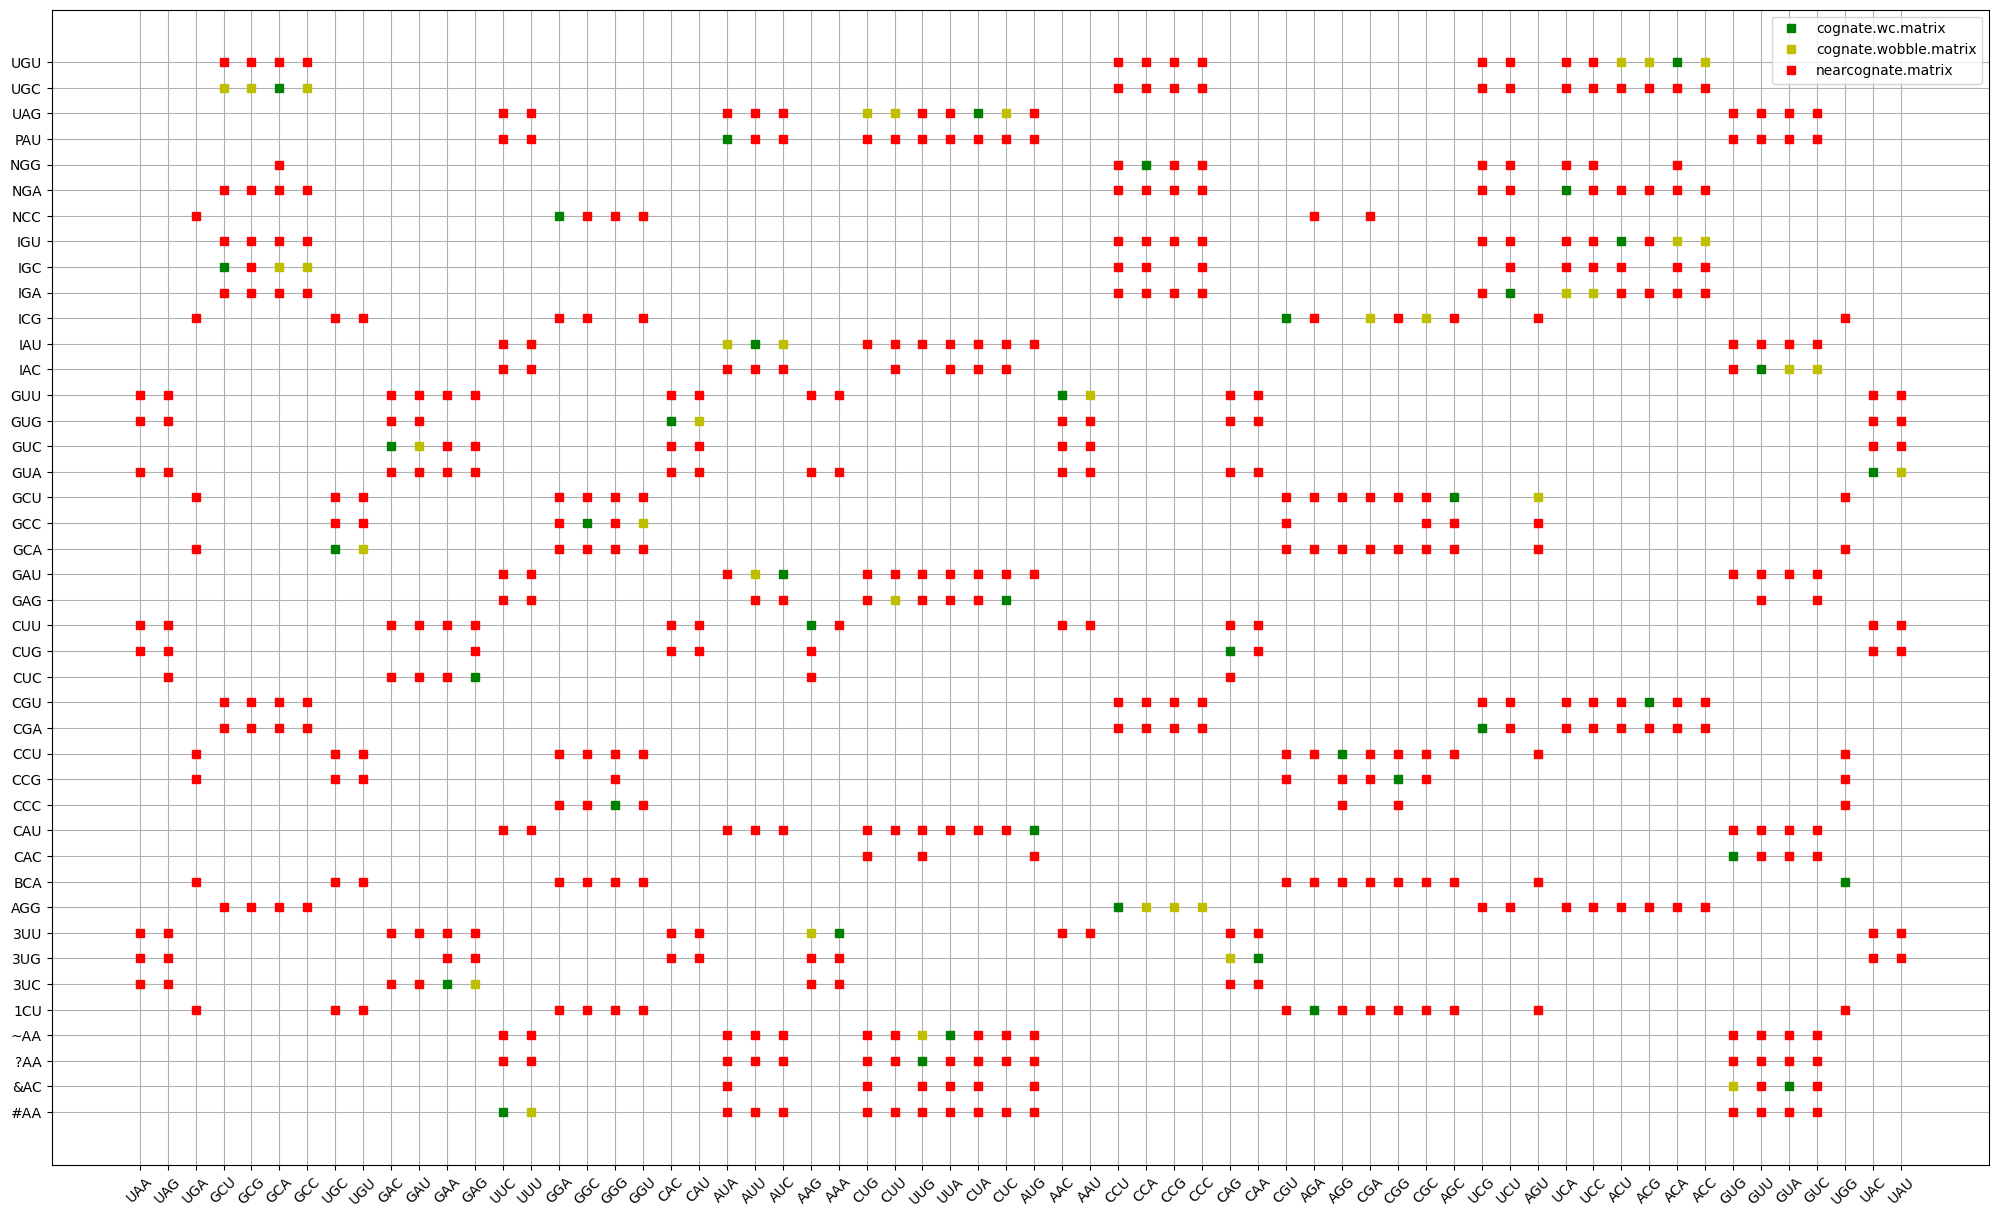

In [3]:
cg.plot_matrix(matrices,tRNAs,codons)

<a name='bp_rules'></a>
<h2>Changing base pairing rules</h2>
<p>Base pairing rules are stored internally as a jason structure. The same structure used internally is represented in the 'baseairing.json' file</p>

In [4]:
#load and inspect the 'basepairing.json' file.
with open('basepairing.json', 'r') as file:
    bpdata = json.load(file)
    print(bpdata)

{'Watson-Crick': {'A': ['U', '&', '3', '1', 'N', '~', ')', 'P'], 'C': ['G', '#'], 'G': ['C', 'B', '?'], 'U': ['A', 'I']}, 'Wobble': {'A': ['A', 'I', 'M', '.'], 'C': ['A', 'U', 'I', 'Q'], 'G': ['A', 'U', '&', '3', '~', 'S', ')', '{', 'V', 'P', '?', 'M', '.'], 'U': ['G', '#', 'W', 'U', 'V', 'I', 'Q']}, 'Pairing Rules': {'Near-Cognate': {'base-level': [['Wo', 'WC', 'X'], ['X', 'WC', 'Wo']]}}}


<p>The rules are stored as a dictionary that defines which pairings are allowed in Watson:Crick base pairs and which are allowed in wobble base pairs. Nucleotide symbols for modified base pairs are generally a used in the <a href='https://genesilico.pl/modomics/' target='_blank'>Modomics</a> Database. The 'Pairing Rules' key defines the minimal conditions when an anticodon:codon pair is considered near-cognate: as shown, this requires a Watson Crick base pair in the central position, and at least one additional wobble base pair in the first or last position. Stronger contacts than those specified are allowed, where the strength increases from 'X' (no contact) < 'Wo' (wobble contact) , 'WC' (Watson Crick contact). The make_matrix method assigns near cognate status to all anticodon:codon pairs that fulfill these specifications and that are not classed as cognate (since cognate tRNAs alsoalways fulfill these criteria).</p>
<p>Alternative rules can be provided by editing values in the file, and changing the 'settings_file_name parameter' of the 'make_matrix' method of the concentration generator.</p>

In [5]:
matrices = cg.make_matrix(tRNAs, codons, settings_file_name='basepairing.json')

<hr>
<a name='Running_simple_model'></a>
<h2>Running a simple codon model</h2>
<a href='#top'>Back to top</a>

In [6]:
#instantiate a codon simulator object
sim=cs.CodonSimulator()
#load the concentrations prepared above into a simulator object
sim.load_concentrations_from_string(concs)
#simulate decoding of an 'AAG' codon 100 times, and retrieve the average decoding cycle time
#(codon decoding plus translocation) in seconds
sim.set_codon_for_simulation('AAG')
result=sim.run_repeatedly_get_average_time(100)
print(result)

0.26207858324050903


In [7]:
#the same as above, but run once and get the separate codon decoding and translocation times in seconds
results=sim.run_and_get_times()
print(results)

(0.3186405301094055, 0.023836486041545868)


In [8]:
#report all ribosome state changes for the most recent simulation run in detail
print(sim.ribosome_state_history)

[0, 1, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 0, 1, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [9]:
#report the time steps between the state changes above
print(sim.dt_history)

[0.0, 2.6612344299792312e-05, 2.8352012577670394e-06, 0.0001562983961775899, 0.0007592373876832426, 0.003874183399602771, 0.005075596272945404, 0.004355193581432104, 0.003066955367103219, 0.014219792559742928, 0.006210211664438248, 0.0021129571832716465, 0.00046640352229587734, 0.00564719270914793, 0.0010838938178494573, 0.0008786669932305813, 0.00152312102727592, 0.004048197064548731, 0.0016026620287448168, 0.00831618346273899, 0.004965604282915592, 0.013543293811380863, 0.0022791086230427027, 3.8961778045631945e-05, 9.148489880317356e-06, 1.2382705790514592e-05, 7.905774509708863e-06, 0.00011059951066272333, 1.952611228261958e-06, 9.510433301329613e-06, 1.4817142982792575e-05, 1.4309430298453663e-05, 0.0008163903257809579, 0.0003748966264538467, 0.0023244901094585657, 0.0008546197204850614, 0.011391531676054, 0.009014415554702282, 0.005477974656969309, 0.005819025915116072, 0.0036948707420378923, 0.008914117701351643, 0.0050634415820240974, 3.6594963148672832e-06, 1.0728012057370506e

<a name='Reaction_rates'></a>
<h2>Changing reaction rate constants</h2>
<a href='#top'>Back to top</a>
<p>Reaction rates are stored internally as a dictionary. Individual reaction rates can be changed by loading the dictionarity into a local variable using the 'get_propensities()' method of the simulator object, then changing the values associated with idnividual keys on thedictionary, then re-loading the altered dictionary into the simulator object using the 'set_propensities()' method.</p>

In [10]:
#load the existing parameters into a dictionary
sim=cs.CodonSimulator()
propensities = sim.get_propensities()
print(propensities)

{'WC1f': 0.0, 'WC1r': 85.0, 'WC2f': 190.0, 'WC2r': 0.23000000417232513, 'WC3f': 260.0, 'WC4f': 1000.0, 'WC5f': 1000.0, 'WC6f': 1000.0, 'WCdiss': 60.0, 'dec7f': 200.0, 'near1f': 0.0, 'near1r': 85.0, 'near2f': 190.0, 'near2r': 80.0, 'near3f': 0.4000000059604645, 'near4f': 1000.0, 'near5f': 1000.0, 'near6f': 60.0, 'neardiss': 1000.0, 'non1f': 0.0, 'non1r': 100000.0, 'trans1f': 2040.0, 'trans1r': 140.0, 'trans2': 250.0, 'trans3': 350.0, 'trans4': 1000.0, 'trans5': 1000.0, 'trans6': 1000.0, 'trans7': 1000.0, 'trans8': 1000.0, 'trans9': 1000.0, 'wobble1f': 0.0, 'wobble1r': 85.0, 'wobble2f': 190.0, 'wobble2r': 1.0, 'wobble3f': 25.0, 'wobble4f': 1000.0, 'wobble5f': 1000.0, 'wobble6f': 6.400000095367432, 'wobblediss': 1.100000023841858}


In [11]:
#instantiate a new simluator object
sim=cs.CodonSimulator()
sim.load_concentrations_from_string(concs)
sim.set_codon_for_simulation('AAG')
propensities = sim.get_propensities()
#set the propensity for the 'WCdiss' reaction to 1000 rather than 60 (the default)

result_before_change = sim.run_repeatedly_get_average_time(1000)
print('Result before parameter change: ' + str(result_before_change))
propensities['WCdiss'] = 1000
sim.set_propensities(propensities)
result_after_change = sim.run_repeatedly_get_average_time(1000)
print('Result after parameter change: ' + str(result_after_change))


Result before parameter change: 0.21844159066677094
Result after parameter change: 0.3168255388736725
